# Chapter: Recurrent Neural Networks


# Topic: Predicting engine RUL usnig LSTM

In [1]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# settings for result reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [2]:
# read data
# training
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True) # last two columns are blank
train_df.columns = ['EngineID', 'cycle', 'OPsetting1', 'OPsetting2', 'OPsetting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# test 
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['EngineID', 'cycle', 'OPsetting1', 'OPsetting2', 'OPsetting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# actual RUL for each engine-id in the test data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True) # 2nd column is blank and thus, dropped
truth_df.columns = ['finalRUL'] # assigning column name as finalRUL
truth_df['EngineID'] = truth_df.index + 1 # adding new column EngineID

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                generate RUL data for training and test dataset
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [3]:
# training dataset
maxCycle_df = pd.DataFrame(train_df.groupby('EngineID')['cycle'].max()).reset_index()
maxCycle_df.columns = ['EngineID', 'maxEngineCycle'] # column maxEngineCycle stores total cycles for an engine until failure

train_df = train_df.merge(maxCycle_df, on=['EngineID'], how='left') 
train_df['engineRUL'] = train_df['maxEngineCycle'] - train_df['cycle'] # column engineRUL stores engine RUL at any given cycle
train_df.drop('maxEngineCycle', axis=1, inplace=True) # maxEngineCycle is not needed anymore
train_df.head()

,EngineID,cycle,OPsetting1,OPsetting2,OPsetting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,engineRUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [4]:
# compute maxEngineCycle for test data using data from test_df and truth_df
maxCycle_df = pd.DataFrame(test_df.groupby('EngineID')['cycle'].max()).reset_index()
maxCycle_df.columns = ['EngineID', 'maxEngineCycle']
truth_df['maxEngineCycle'] = maxCycle_df['maxEngineCycle'] + truth_df['finalRUL'] 
truth_df.drop('finalRUL', axis=1, inplace=True)

# generate engineRUL for test data
test_df = test_df.merge(truth_df, on=['EngineID'], how='left')
test_df['engineRUL'] = test_df['maxEngineCycle'] - test_df['cycle']
test_df.drop('maxEngineCycle', axis=1, inplace=True)
test_df.head()

,EngineID,cycle,OPsetting1,OPsetting2,OPsetting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,engineRUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


In [6]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##       clip RUL in training data at the threshold 150
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
RULthreshold = 150
train_df['engineRUL'] = np.where(train_df['engineRUL'] > RULthreshold, 150, train_df['engineRUL'])

In [7]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                             scale training and test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# training data: create temporary dataframe with columns to be scaled
all_cols = train_df.columns # get columns names
cols_to_scale = train_df.columns.difference(['EngineID','cycle','engineRUL']) # returns all column labels except these specified
train_df_with_cols_to_scale = train_df[cols_to_scale]

# scale and rejoin with columns that were not scaled
scaler = StandardScaler()
scaled_train_df_with_cols_to_scale = pd.DataFrame(scaler.fit_transform(train_df_with_cols_to_scale), columns=cols_to_scale) # transform returns a numpy array
train_df_scaled = train_df[['EngineID','cycle','engineRUL']].join(scaled_train_df_with_cols_to_scale) # join back non-scaled columns
train_df_scaled = train_df_scaled.reindex(columns = all_cols) # same columns order as before

# test data: repeat above steps
all_cols = test_df.columns
test_df_with_cols_to_scale = test_df[cols_to_scale]
scaled_test_df_with_cols_to_scale = pd.DataFrame(scaler.transform(test_df_with_cols_to_scale), columns=cols_to_scale) # transform returns a numpy array
test_df_scaled = test_df[['EngineID','cycle','engineRUL']].join(scaled_test_df_with_cols_to_scale) # join back non-scaled columns
test_df_scaled = test_df_scaled.reindex(columns = all_cols) # same columns order as before

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##            re-format data into (samples, time steps, features) form
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [8]:
# define utility function
def generate_LSTM_samples(engine_df, nSequenceSteps):
    """
        This function generates list of LSTM samples (numpy arrays of size (nSequenceSteps, 24) each) for LSTM input
        and list of output labels for LSTM
    """
    engine_X_train_sequence = []
    engine_y_train_sequence = []
    engine_data = engine_df.values # converting to numpy
    
    for sample in range(nSequenceSteps, engine_data.shape[0]):
        engine_X_train_sequence.append(engine_data[sample-nSequenceSteps:sample,:-1]) # last column is output label
        engine_y_train_sequence.append(engine_data[sample,-1])
    
    return engine_X_train_sequence, engine_y_train_sequence

In [9]:
nSequenceSteps = 50 # number of cycles in a sequence
X_train_sequence = []
y_train_sequence = []

# generate samples
for engineID in train_df_scaled['EngineID'].unique():
    engine_df = train_df_scaled[train_df_scaled['EngineID'] == engineID]
    engine_df = engine_df[['OPsetting1', 'OPsetting2', 'OPsetting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                           's15', 's16', 's17', 's18', 's19', 's20', 's21', 'engineRUL']]
    engine_X_train_sequence, engine_y_train_sequence = generate_LSTM_samples(engine_df, nSequenceSteps)
    
    X_train_sequence = X_train_sequence + engine_X_train_sequence # adding samples to the common list
    y_train_sequence = y_train_sequence + engine_y_train_sequence

X_train_sequence, y_train_sequence = np.array(X_train_sequence), np.array(y_train_sequence) # convert list of (time steps, features) array into (samples, time steps, features) array


In [10]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                       define and fit LSTM model
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# custom metric
import tensorflow.keras.backend as K
def r2_custom(y_true, y_pred):
    """Coefficient of determination 
    """
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

# define model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(nSequenceSteps, 24)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           50000     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 80,251
Trainable params: 80,251
Non-trainable params: 0
_________________________________________________________________


In [11]:
# compile model
model.compile(loss='mse', optimizer='Adam', metrics=r2_custom)

#%% fit model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_sequence, y_train_sequence, epochs=200, batch_size=250, validation_split=0.3, callbacks=[es])

Epoch 1/200
44/44 [==============================] - 6s 143ms/step - loss: 7296.5952 - r2_custom: -2.4153 - val_loss: 7790.8369 - val_r2_custom: -2.7878
Epoch 2/200
44/44 [==============================] - 6s 134ms/step - loss: 6490.0757 - r2_custom: -2.0446 - val_loss: 7366.6782 - val_r2_custom: -2.5709
Epoch 3/200
44/44 [==============================] - 6s 139ms/step - loss: 6160.8242 - r2_custom: -1.8881 - val_loss: 7034.9565 - val_r2_custom: -2.4018
Epoch 4/200
44/44 [==============================] - 5s 117ms/step - loss: 5870.1484 - r2_custom: -1.7491 - val_loss: 6719.7051 - val_r2_custom: -2.2415
Epoch 5/200
44/44 [==============================] - 5s 114ms/step - loss: 5588.1353 - r2_custom: -1.6195 - val_loss: 6425.0967 - val_r2_custom: -2.0923
Epoch 6/200
44/44 [==============================] - 5s 112ms/step - loss: 5332.7295 - r2_custom: -1.4979 - val_loss: 6152.0791 - val_r2_custom: -1.9544
Epoch 7/200
44/44 [==============================] - 5s 109ms/step - loss: 5097.76

Epoch 55/200
44/44 [==============================] - 5s 113ms/step - loss: 586.1240 - r2_custom: 0.7261 - val_loss: 854.5893 - val_r2_custom: 0.6079
Epoch 56/200
44/44 [==============================] - 5s 110ms/step - loss: 570.0819 - r2_custom: 0.7339 - val_loss: 882.7885 - val_r2_custom: 0.5967
Epoch 57/200
44/44 [==============================] - 5s 109ms/step - loss: 542.0322 - r2_custom: 0.7466 - val_loss: 812.0324 - val_r2_custom: 0.6250
Epoch 58/200
44/44 [==============================] - 5s 110ms/step - loss: 512.4746 - r2_custom: 0.7607 - val_loss: 789.4245 - val_r2_custom: 0.6326
Epoch 59/200
44/44 [==============================] - 5s 109ms/step - loss: 497.6783 - r2_custom: 0.7673 - val_loss: 762.8979 - val_r2_custom: 0.6430
Epoch 60/200
44/44 [==============================] - 5s 110ms/step - loss: 475.6728 - r2_custom: 0.7778 - val_loss: 762.7850 - val_r2_custom: 0.6466
Epoch 61/200
44/44 [==============================] - 5s 109ms/step - loss: 461.3660 - r2_custom: 0.

44/44 [==============================] - 5s 114ms/step - loss: 79.8475 - r2_custom: 0.9626 - val_loss: 396.3402 - val_r2_custom: 0.7934
Epoch 110/200
44/44 [==============================] - 5s 115ms/step - loss: 76.7294 - r2_custom: 0.9640 - val_loss: 423.1941 - val_r2_custom: 0.7825
Epoch 111/200
44/44 [==============================] - 5s 111ms/step - loss: 72.4146 - r2_custom: 0.9661 - val_loss: 415.8084 - val_r2_custom: 0.7844
Epoch 112/200
44/44 [==============================] - 5s 115ms/step - loss: 76.0045 - r2_custom: 0.9644 - val_loss: 398.0211 - val_r2_custom: 0.7876
Epoch 113/200
44/44 [==============================] - 5s 112ms/step - loss: 72.2117 - r2_custom: 0.9661 - val_loss: 409.6957 - val_r2_custom: 0.7904
Epoch 114/200
44/44 [==============================] - 5s 110ms/step - loss: 69.8739 - r2_custom: 0.9673 - val_loss: 430.9116 - val_r2_custom: 0.7755
Epoch 115/200
44/44 [==============================] - 5s 112ms/step - loss: 70.1658 - r2_custom: 0.9672 - val_los

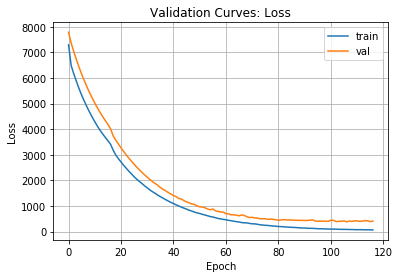

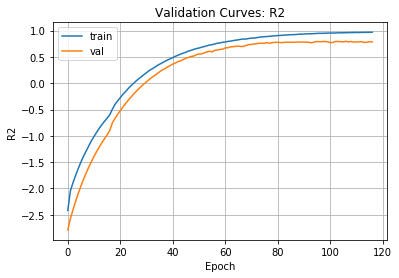

In [12]:
# plot validation curve
plt.figure()
plt.title('Validation Curves: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.title('Validation Curves: R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.plot(history.history['r2_custom'], label='train')
plt.plot(history.history['val_r2_custom'], label='val')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         evaluate model on test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [13]:
# input/output test sequences (only the last sequence is used to predict failure)
X_test_sequence = []
y_test_sequence = []

for engineID in test_df_scaled['EngineID'].unique():
    engine_df = test_df_scaled[test_df_scaled['EngineID'] == engineID]
    
    if engine_df.shape[0] >= nSequenceSteps:
        engine_df = engine_df[['OPsetting1', 'OPsetting2', 'OPsetting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                           's15', 's16', 's17', 's18', 's19', 's20', 's21', 'engineRUL']].values
        X_test_sequence.append(engine_df[-nSequenceSteps:,:-1])
        y_test_sequence.append(engine_df[-1,-1])
        
X_test_sequence, y_test_sequence = np.array(X_test_sequence), np.array(y_test_sequence)

In [14]:
# evaluate performance
test_performance = model.evaluate(X_test_sequence, y_test_sequence)
print('R2_test: {}'.format(test_performance[1]))

3/3 [==============================] - 0s 6ms/step - loss: 265.5893 - r2_custom: 0.8348
R2_test: 0.8347665667533875


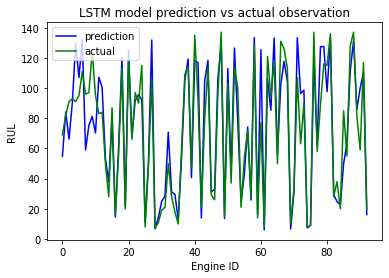

In [15]:
# plot
y_test_sequence_pred = model.predict(X_test_sequence)

plt.figure()
plt.plot(y_test_sequence_pred, color="blue", label='prediction')
plt.plot(y_test_sequence, color="green", label='actual')
plt.title('LSTM model prediction vs actual observation')
plt.ylabel('RUL')
plt.xlabel('Engine ID')
plt.legend(loc='upper left')
plt.show()